In [12]:
library(ArchR)
library(BSgenome.Hsapiens.UCSC.hg38)
set.seed(1)
threads <- parallel::detectCores() - 1
addArchRThreads(threads = threads)
addArchRLocking(FALSE)
addArchRGenome("hg38")

Input threads is equal to or greater than ncores minus 1 (63)
Setting cores to ncores minus 2. Set force = TRUE to set above this number!

Setting default number of Parallel threads to 62.

Setting ArchRLocking to FALSE.

Setting default genome to Hg38.



In [13]:
# ==============================================================================
# 1. Define Input Files
# ==============================================================================
collab_dir <- "../../../data/data_raw/collaborators/processed"
pub_dir   <- "../../../data/data_raw/granja/hg38"

In [14]:
pub_frags    <- list.files(pub_dir,
                           pattern = "\\.fragments\\.tsv\\.gz$",
                           full.names = TRUE)
pub_frags <- pub_frags[!grepl("lt120", pub_frags)]

pub_raw <- sub("_hg38\\.fragments\\.tsv\\.gz$", "", basename(pub_frags))
pub_suffixes <- sub(".*(_D\\d+T\\d+)$", "\\1", pub_raw)
pub_names <- paste0("granja", pub_suffixes)

In [15]:
all_frags  <- c(
  file.path(collab_dir, "collab_donor0_fragments.tsv.gz"),
  file.path(collab_dir, "collab_donor1_fragments.tsv.gz"),
  pub_frags
)
all_names  <- c("collab_0", "collab_1", pub_names)

In [16]:
# ==============================================================================
# 2. QC Filter Thresholds
# ==============================================================================

minTSS   <- 8
minFrags <- 1000

In [17]:
# ==============================================================================
# 3. Create Arrow Files WITH Filters Applied Directly
# ==============================================================================

arrow_files <- createArrowFiles(
  inputFiles      = all_frags,
  sampleNames     = all_names,
  minFrags        = minFrags,
  minTSS          = minTSS,
  addTileMat      = TRUE,
  addGeneScoreMat = FALSE#,
  #force           = TRUE
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-fe696272064b-Date-2026-01-20_Time-20-31-55.001502.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

Disabling H5 File Locking. If this is not desired check `addArchRLocking`.

subThreading Enabled since ArchRLocking is FALSE see `addArchRLocking`

2026-01-20 20:31:55.75559 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-fe696272064b-Date-2026-01-20_Time-20-31-55.001502.log



In [18]:
# ==============================================================================
# 4. Create ArchR Project
# ==============================================================================
proj <- ArchRProject(
  ArrowFiles      = arrow_files,
  outputDirectory = "ArchR_Collab_vs_Pub_QCFiltered",
  copyArrows      = FALSE
)

# Add Tissue metadata
tissue_lookup <- setNames(
  ifelse(grepl("^collab_", all_names), "MobilizedBlood", "BoneMarrow"),
  all_names
)

proj <- addCellColData(
  proj,
  data  = tissue_lookup[proj$Sample],
  cells = proj$cellNames,
  name  = "Tissue"
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

In [19]:
# ==============================================================================
# 5. Doublet Detection and Removal
# ==============================================================================
proj <- addDoubletScores(
  proj,
  dimsToUse = 1:20,
  force     = TRUE
)

proj <- filterDoublets(proj)

cat("\n=== After QC + Doublet Removal ===\n")
cat("Total cells:", length(proj$cellNames), "\n")

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-fe693946be22-Date-2026-01-20_Time-20-44-06.318831.log
If there is an issue, please report to github with logFile!

2026-01-20 20:44:06.952658 : Batch Execution w/ safelapply!, 0 mins elapsed.

2026-01-20 20:44:06.968143 : collab_0 (1 of 5) :  Computing Doublet Statistics, 0 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

collab_0 (1 of 5) : UMAP Projection R^2 = 0.96865

collab_0 (1 of 5) : UMAP Projection R^2 = 0.96865

2026-01-20 20:48:18.143274 : collab_1 (2 of 5) :  Computing Doublet Statistics, 4.187 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

collab_1 (2 of 5) : UMAP Projection R^2 = 0.98765

collab_1 (2 of 5) : UMAP Projection R^2 = 0.98765

2026-01-20 20:51:49.767314 : granja_D8T1 (3 of 5) :  Computing Doublet Statistics, 7.714 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Biased Clusters : 
Cluste


=== After QC + Doublet Removal ===
Total cells: 17612 


In [20]:
# Show createArrowFiles content
print(arrow_files)
length(arrow_files)

[1] "granja_D7T1.arrow" "collab_0.arrow"    "granja_D8T1.arrow"
[4] "collab_1.arrow"    "granja_D9T1.arrow"


[1] 5

In [21]:
# ==============================================================================
# 6. Create Gene Score Matrix
# ==============================================================================
proj <- addGeneScoreMatrix(
  input            = proj,
  genes            = getGenes(proj),
  force            = TRUE
)

# Verify gene score matrix was added
cat("\n=== Available Matrices ===\n")
print(getAvailableMatrices(proj))

ArchR logging to : ArchRLogs/ArchR-addGeneScoreMatrix-fe693f0f2090-Date-2026-01-20_Time-21-00-38.482924.log
If there is an issue, please report to github with logFile!

subThreading Enabled since ArchRLocking is FALSE and subThreading is TRUE see `addArchRLocking`

2026-01-20 21:00:39.311555 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addGeneScoreMatrix-fe693f0f2090-Date-2026-01-20_Time-21-00-38.482924.log



Plotting Ggplot!




=== Cell Counts by Sample ===

   collab_0    collab_1 granja_D7T1 granja_D8T1 granja_D9T1 
       3688        3358        3204        3490        3872 

=== Cell Counts by Tissue ===

    BoneMarrow MobilizedBlood 
         10566           7046 

=== TSS Statistics ===
       Sample TSSEnrichment_median TSSEnrichment_mean
1    collab_0              14.0430           14.39700
2    collab_1              13.6295           14.01445
3 granja_D7T1              15.1400           15.15525
4 granja_D8T1              15.5430           15.57357
5 granja_D9T1              16.3320           16.43420


1 


1 


1 
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the ArchR package.
  Please report the issue to the authors.”


1 




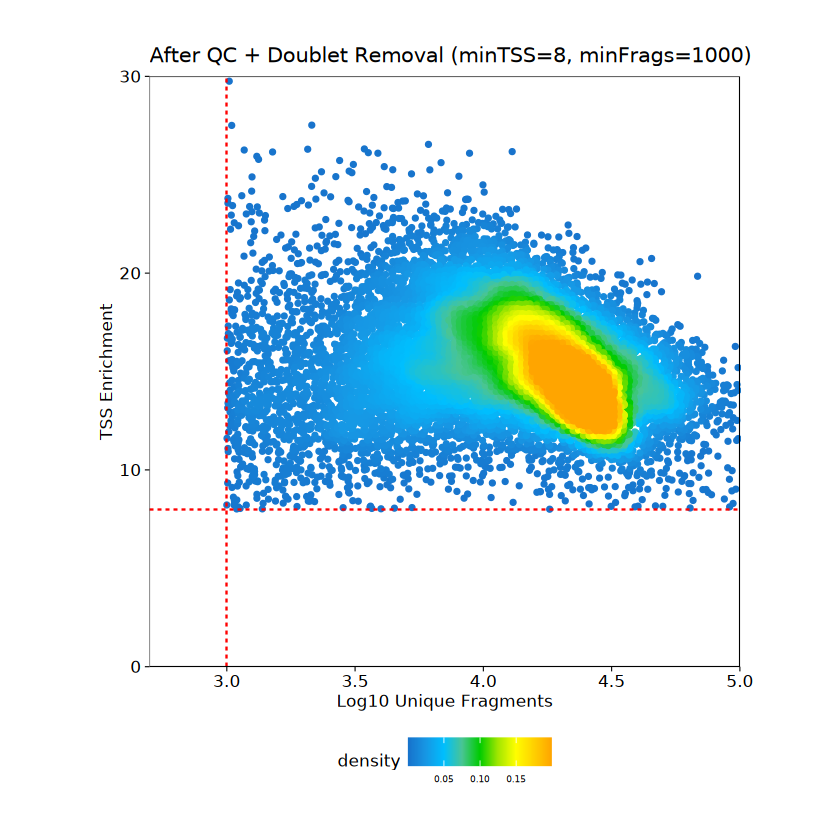

In [22]:
# ==============================================================================
# 7. QC Visualization
# ==============================================================================

# Get cell metadata
df <- getCellColData(proj, select = c("Sample", "log10(nFrags)", "TSSEnrichment"))

# TSS vs Frags scatter plot
p_qc <- ggPoint(
  x = df[, 2],
  y = df[, 3],
  colorDensity = TRUE,
  continuousSet = "sambaNight",
  xlabel = "Log10 Unique Fragments",
  ylabel = "TSS Enrichment",
  xlim = c(log10(500), 5),
  ylim = c(0, 30)
) +
  geom_hline(yintercept = minTSS, lty = "dashed", color = "red") +
  geom_vline(xintercept = log10(minFrags), lty = "dashed", color = "red") +
  ggtitle(paste0("After QC + Doublet Removal (minTSS=", minTSS, ", minFrags=", minFrags, ")"))

print(p_qc)
plotPDF(p_qc, name = "TSS-vs-Frags-Final.pdf", ArchRProj = proj, addDOC = FALSE)

# Cell counts
cat("\n=== Cell Counts by Sample ===\n")
print(table(proj$Sample))

cat("\n=== Cell Counts by Tissue ===\n")
print(table(proj$Tissue))

# TSS statistics
tss_median <- aggregate(TSSEnrichment ~ Sample, data = df, FUN = median)
tss_mean   <- aggregate(TSSEnrichment ~ Sample, data = df, FUN = mean)
tss_stats  <- merge(tss_median, tss_mean, by = "Sample", suffixes = c("_median", "_mean"))
cat("\n=== TSS Statistics ===\n")
print(tss_stats)

# Ridge plots by Sample
p1 <- plotGroups(
  ArchRProj = proj,
  groupBy   = "Sample",
  colorBy   = "cellColData",
  name      = "TSSEnrichment",
  plotAs    = "ridges",
  baseSize  = 10
)

p2 <- plotGroups(
  ArchRProj = proj,
  groupBy   = "Sample",
  colorBy   = "cellColData",
  name      = "log10(nFrags)",
  plotAs    = "ridges",
  baseSize  = 10
)

# Violin plots by Tissue
p3 <- plotGroups(
  ArchRProj  = proj,
  groupBy    = "Tissue",
  colorBy    = "cellColData",
  name       = "TSSEnrichment",
  plotAs     = "violin",
  alpha      = 0.4,
  baseSize   = 10,
  addBoxPlot = TRUE,
  pal        = c("BoneMarrow" = "#29306B", "MobilizedBlood" = "#D51F26")
)

p4 <- plotGroups(
  ArchRProj  = proj,
  groupBy    = "Tissue",
  colorBy    = "cellColData",
  name       = "log10(nFrags)",
  plotAs     = "violin",
  alpha      = 0.4,
  baseSize   = 10,
  addBoxPlot = TRUE,
  pal        = c("BoneMarrow" = "#29306B", "MobilizedBlood" = "#D51F26")
)


Plotting Ggplot!

Picking joint bandwidth of 0.49

Picking joint bandwidth of 0.49

Plotting Ggplot!

Picking joint bandwidth of 0.0569

Picking joint bandwidth of 0.0569

Plotting Ggplot!

Plotting Ggplot!

Picking joint bandwidth of 0.49

Picking joint bandwidth of 0.0569



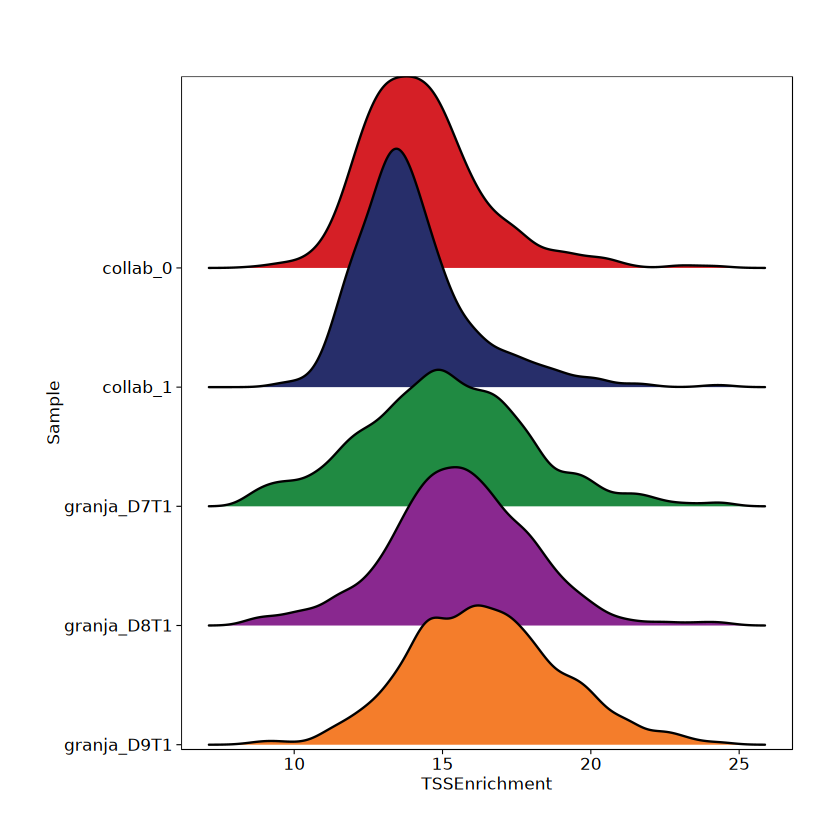

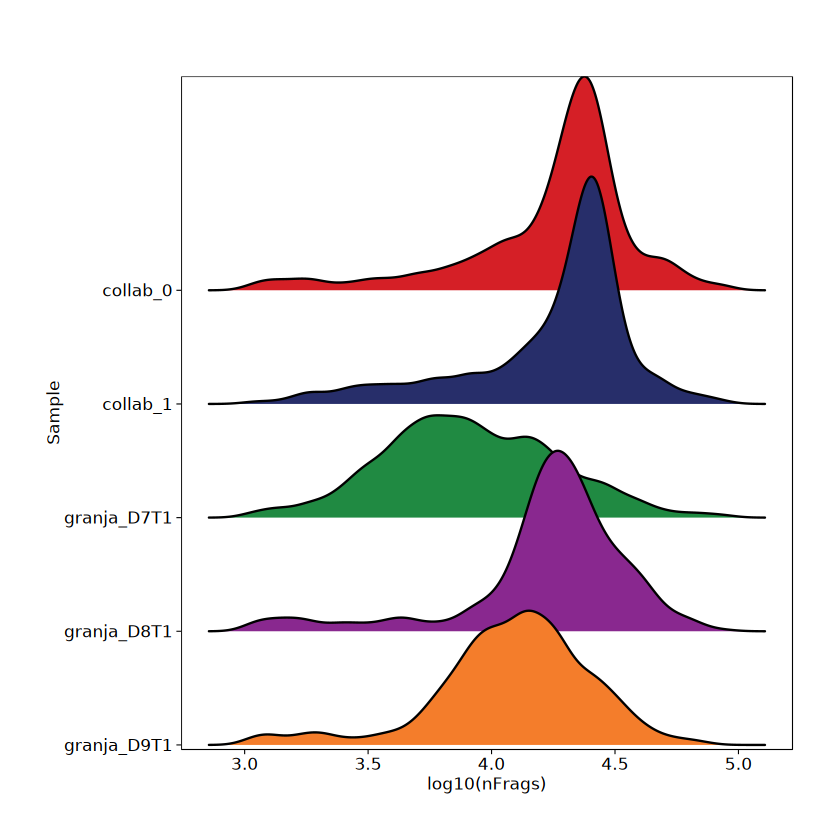

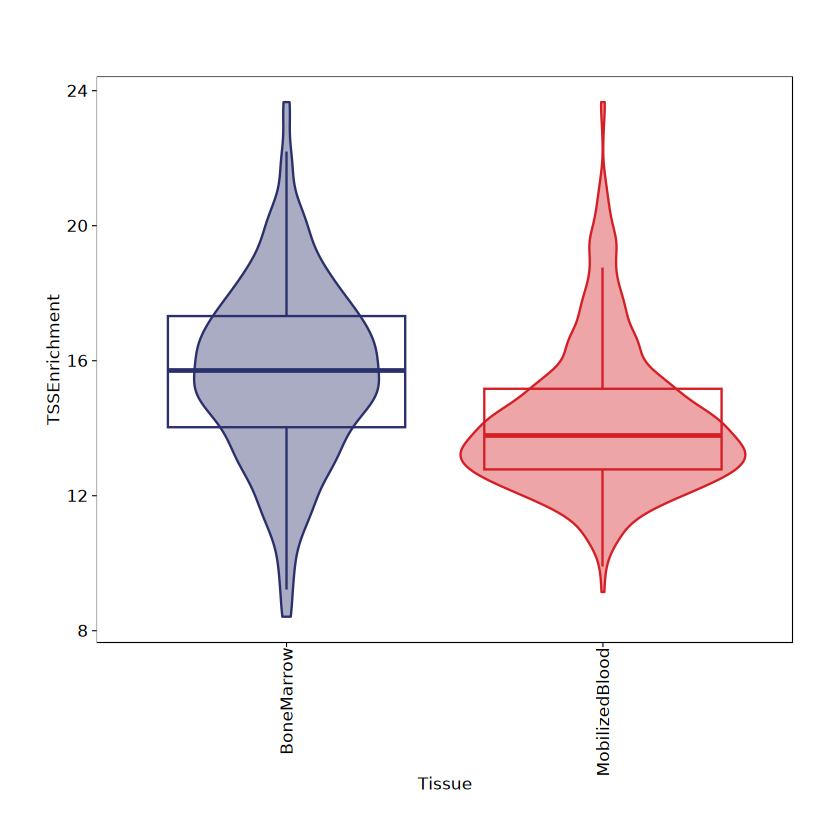

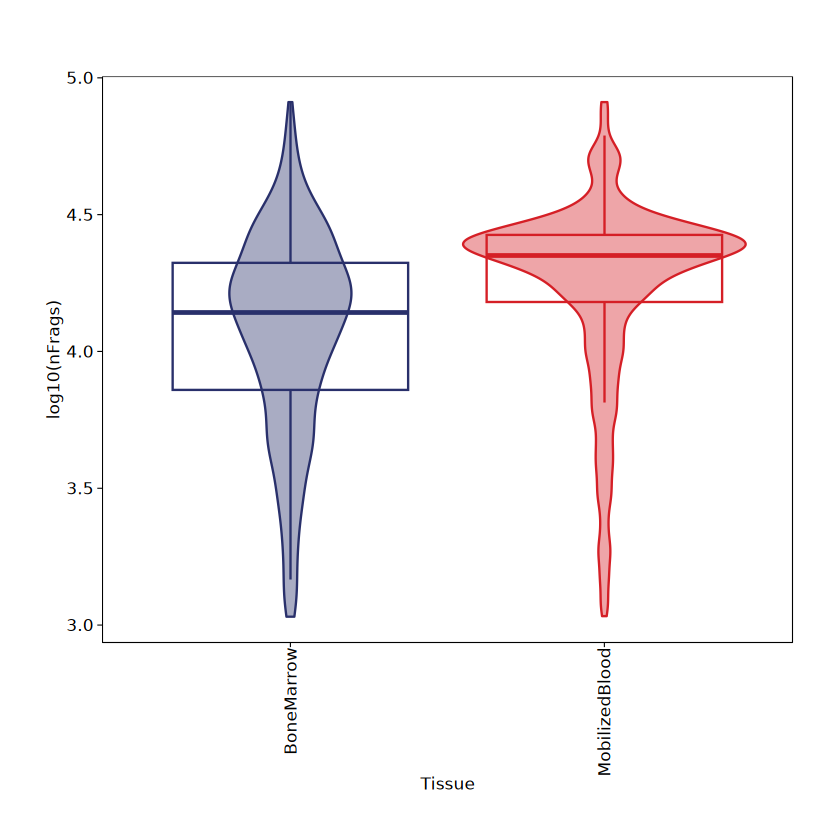

In [26]:
plotPDF(p1, p2, p3, p4, name = "QC-Plots-Sample-Tissue.pdf", 
        ArchRProj = proj, addDOC = FALSE, width = 8, height = 6)
p1
p2
p3
p4

In [24]:
# Fragment size distribution and TSS enrichment profile
p_frag <- plotFragmentSizes(ArchRProj = proj)
p_tss  <- plotTSSEnrichment(ArchRProj = proj)

plotPDF(p_frag, p_tss, name = "FragSizes-TSSProfile.pdf", 
        ArchRProj = proj, addDOC = FALSE, width = 5, height = 5)

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-fe696abd2912-Date-2026-01-20_Time-21-03-48.042109.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-fe696abd2912-Date-2026-01-20_Time-21-03-48.042109.log

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ArchR package.
  Please report the issue to the authors.”
ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-fe696a0f6ae-Date-2026-01-20_Time-21-05-39.542926.log
If there is an issue, please report to github with logFile!

Disabling H5 File Locking. If this is not desired check `addArchRLocking`.

subThreading Enabled since ArchRLocking is FALSE see `addArchRLocking`



R_zmq_msg_send errno: 4 strerror: Unterbrechung während des Betriebssystemaufrufs
R_zmq_msg_send errno: 4 strerror: Unterbrechung während des Betriebssystemaufrufs
R_zmq_msg_send errno: 4 strerror: Unterbrechung während des Betriebssystemaufrufs


ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-fe696a0f6ae-Date-2026-01-20_Time-21-05-39.542926.log

Plotting Ggplot!

Plotting Ggplot!




Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union


Das folgende Objekt ist maskiert ‘package:XVector’:

    slice


Das folgende Objekt ist maskiert ‘package:Biobase’:

    combine


Die folgenden Objekte sind maskiert von ‘package:GenomicRanges’:

    intersect, setdiff, union


Das folgende Objekt ist maskiert ‘package:GenomeInfoDb’:

    intersect


Die folgenden Objekte sind maskiert von ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


Die folgenden Objekte sind maskiert von ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


Die folgenden Objekte sind maskiert von ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


Das folgende Objekt ist maskiert ‘package:matrixStats’:

    count


Die folgenden Objekte sind maskiert von ‘package:data.table’:

    between, first, last


Die folgenden Objekte sind maskiert von ‘package:plyr’:


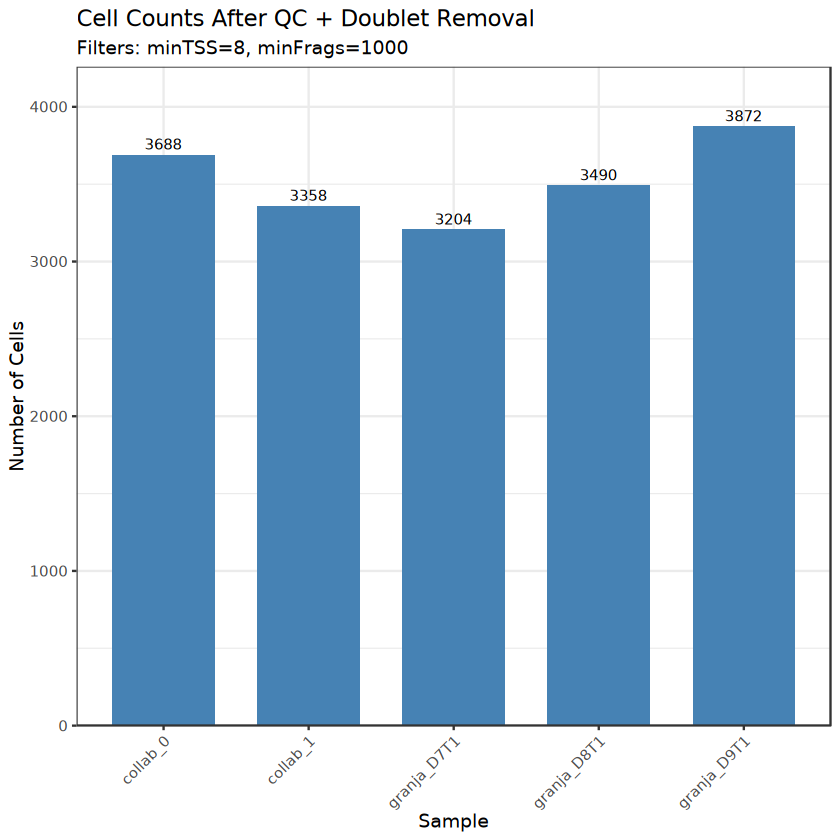

Plotting Ggplot!



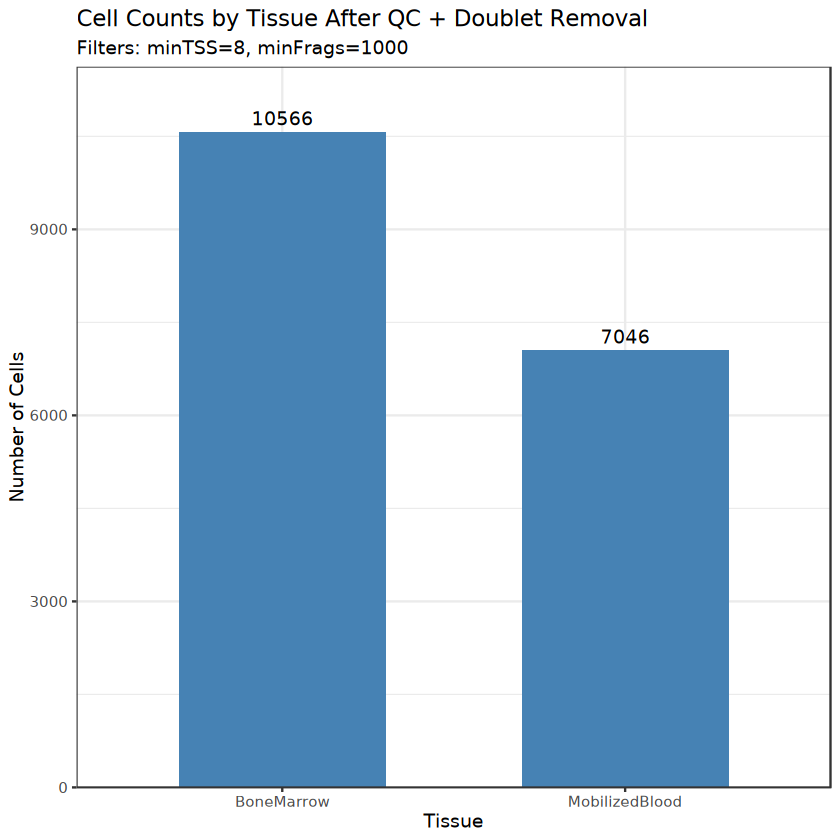

In [25]:
# ==============================================================================
# 8. Cell Count Summary Plots
# ==============================================================================
library(ggplot2)
library(dplyr)

df_summary <- as.data.frame(getCellColData(proj)) %>%
  group_by(Sample, Tissue) %>%
  summarise(Cells = n(), .groups = "drop")

# Plot: Cells per sample
p_cells_sample <- ggplot(df_summary, aes(x = Sample, y = Cells)) +
  geom_bar(stat = "identity", fill = "steelblue", width = 0.7) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title    = "Cell Counts After QC + Doublet Removal",
    subtitle = paste0("Filters: minTSS=", minTSS, ", minFrags=", minFrags),
    y        = "Number of Cells"
  ) +
  geom_text(aes(label = Cells), vjust = -0.5, size = 3) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1)))

print(p_cells_sample)
plotPDF(p_cells_sample, name = "Cell-Counts-Sample-Final.pdf", 
        ArchRProj = proj, addDOC = FALSE, width = 10, height = 6)

# Plot: Cells per tissue
df_tissue <- df_summary %>%
  group_by(Tissue) %>%
  summarise(Cells = sum(Cells), .groups = "drop")

p_cells_tissue <- ggplot(df_tissue, aes(x = Tissue, y = Cells)) +
  geom_bar(stat = "identity", fill = "steelblue", width = 0.6) +
  theme_bw() +
  labs(
    title    = "Cell Counts by Tissue After QC + Doublet Removal",
    subtitle = paste0("Filters: minTSS=", minTSS, ", minFrags=", minFrags),
    y        = "Number of Cells"
  ) +
  geom_text(aes(label = Cells), vjust = -0.5, size = 4) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1)))

print(p_cells_tissue)
plotPDF(p_cells_tissue, name = "Cell-Counts-Tissue-Final.pdf", 
        ArchRProj = proj, addDOC = FALSE, width = 8, height = 6)


ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-1df8366b1db4-Date-2025-12-14_Time-23-16-49.786584.log
If there is an issue, please report to github with logFile!

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-1df8366b1db4-Date-2025-12-14_Time-23-16-49.786584.log



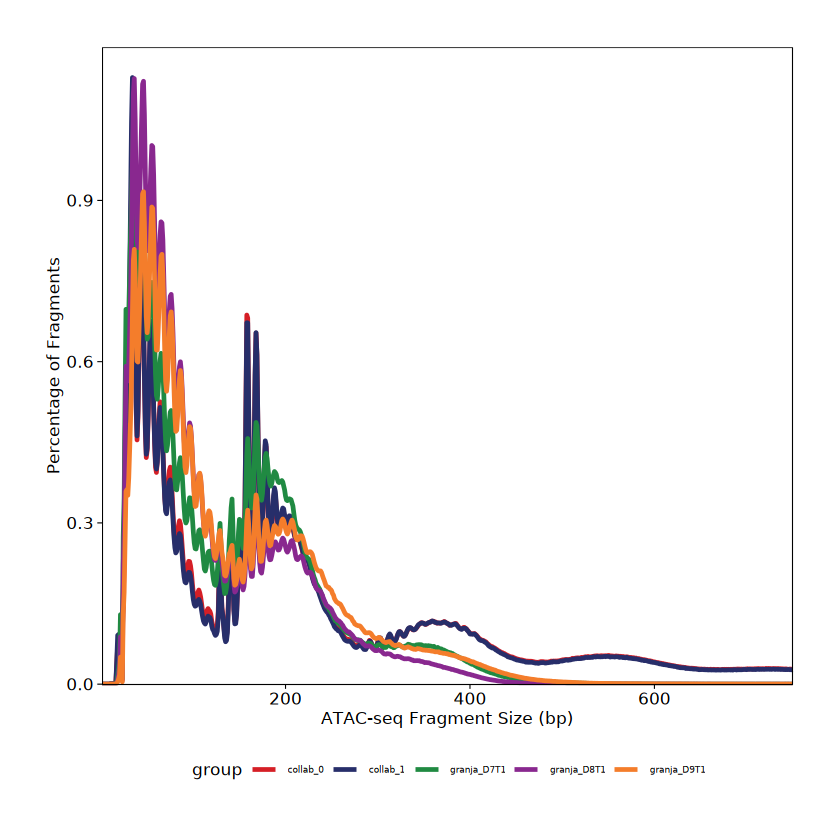

In [31]:
#FragmentSize Distribution
p5 <- plotFragmentSizes(ArchRProj = proj)
p5

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-1df81b42546c-Date-2025-12-14_Time-23-20-10.113576.log
If there is an issue, please report to github with logFile!

Disabling H5 File Locking. If this is not desired check `addArchRLocking`.

subThreading Enabled since ArchRLocking is FALSE see `addArchRLocking`

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-1df81b42546c-Date-2025-12-14_Time-23-20-10.113576.log



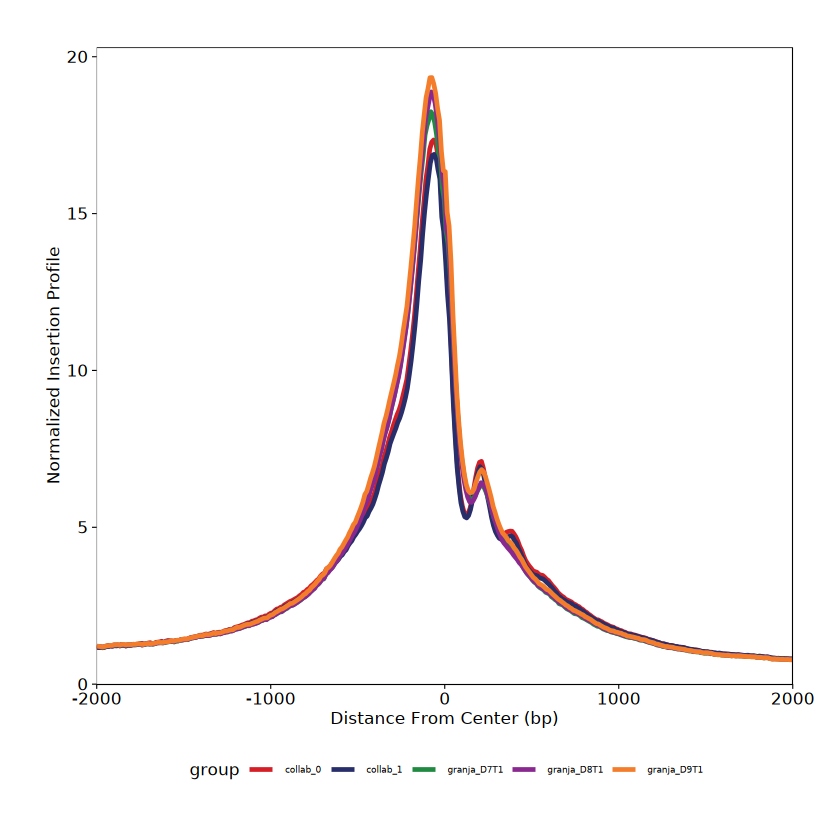

In [32]:
# TSS Enrichment Distribution
p6 <- plotTSSEnrichment(ArchRProj = proj)
p6

In [ ]:
# ==============================================================================
# 9. Save Project
# ==============================================================================
saveArchRProject(proj, outputDirectory = "ArchR_Collab_vs_Pub_Final", load = FALSE)